Universidad del Valle de Guatemala <br>
Deep Learning <br>
Sec. 20 <br>
Proyecto Final <br>

Integrantes: <br>
Javier Chávez 21016 <br>
Mario Cristales 21631 <br>
Andres Quezada 21085 <br>


In [11]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

file_path = '/content/drive/My Drive/ColabData/blackjack.csv'
data = pd.read_csv(file_path, nrows=100000)

data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,10,"[10, 11]","[10, 4, 10]",24,"[[10, 11]]",['BJ'],[['S']],1,0,1.5
1,0,411,10,"[5, 5]","[10, 8]",18,"[[5, 5, 11]]",[21],"[['H', 'S']]",-2,0,1.0
2,0,406,6,"[3, 10]","[6, 6, 10]",22,"[[3, 10]]",[13],[['S']],-2,0,1.0
3,0,401,10,"[5, 9]","[10, 8]",18,"[[5, 9, 11, 3]]",[18],"[['H', 'H', 'S']]",-1,0,0.0
4,0,395,8,"[6, 10]","[8, 2, 10]",20,"[[6, 10, 10]]",[26],[['H']],-1,0,-1.0


In [12]:
# 1. Seleccionar las columnas relevantes
# Incluimos 'cards_remaining', 'dealer_up', 'initial_hand', 'run_count', 'true_count', 'actions_taken'
data = data[['cards_remaining', 'dealer_up', 'initial_hand', 'run_count', 'true_count', 'actions_taken']]

# 2. Transformación de las cartas
# 'dealer_up' y 'initial_hand' contienen valores de cartas, así que extraeremos sus valores numéricos

# Función para convertir el valor de la carta en numérico
def card_value(card):
    if card in ["J", "Q", "K"]:
        return 10
    elif card == "A":
        return 11  # Asumimos que el As vale 11 inicialmente
    else:
        return int(card)

# Convertir 'dealer_up' en valor numérico
data['dealer_up'] = data['dealer_up'].apply(lambda x: card_value(str(x)))

# Convertir 'initial_hand' en una lista de valores numéricos
data['initial_hand'] = data['initial_hand'].apply(lambda x: [card_value(card) for card in eval(x)])

# Separar las dos cartas de 'initial_hand' en dos columnas
data['initial_card_1'] = data['initial_hand'].apply(lambda x: x[0] if len(x) > 0 else 0)
data['initial_card_2'] = data['initial_hand'].apply(lambda x: x[1] if len(x) > 1 else 0)

# Calcular el valor inicial de la mano del jugador
def calculate_hand_value(hand):
    value = sum(hand)
    aces = hand.count(11)
    # Ajustar el valor del As si es necesario
    while value > 21 and aces:
        value -= 10  # Convertir un As de 11 a 1
        aces -= 1
    return value

data['player_hand_value'] = data[['initial_card_1', 'initial_card_2']].apply(lambda x: calculate_hand_value([x['initial_card_1'], x['initial_card_2']]), axis=1)

# Eliminar la columna 'initial_hand' original, ya que ahora tenemos sus dos componentes
data.drop(columns=['initial_hand'], inplace=True)

# 3. Codificación de 'actions_taken' como valores numéricos
# Limpiar y transformar 'actions_taken' para extraer la primera acción tomada

# Filtrar filas con valores nulos o vacíos en 'actions_taken'
data = data.dropna(subset=['actions_taken'])

# Función para evaluar y extraer la primera acción de 'actions_taken'
def safe_eval(action):
    try:
        # Intentamos extraer la primera acción
        action_list = eval(action)
        if isinstance(action_list, list) and len(action_list) > 0 and len(action_list[0]) > 0:
            return action_list[0][0]  # Extraemos la primera acción
        else:
            return None
    except (IndexError, SyntaxError, TypeError, NameError):
        return None  # Retorna None si el formato es incorrecto

# Aplicar la función a 'actions_taken' y eliminar filas inválidas
data['actions_taken'] = data['actions_taken'].apply(safe_eval)
data = data.dropna(subset=['actions_taken'])

# Convertir 'actions_taken' a valores numéricos usando LabelEncoder
encoder = LabelEncoder()
data['actions_taken'] = encoder.fit_transform(data['actions_taken'])

# 4. Normalización de 'cards_remaining', 'run_count', 'true_count', y 'player_hand_value'
scaler = StandardScaler()
data[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']] = scaler.fit_transform(
    data[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']]
)

# Visualizar los datos después del preprocesamiento
data.head()


<ipython-input-12-883a5df1c263>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dealer_up'] = data['dealer_up'].apply(lambda x: card_value(str(x)))
<ipython-input-12-883a5df1c263>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['actions_taken'] = encoder.fit_transform(data['actions_taken'])
<ipython-input-12-883a5df1c263>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,cards_remaining,dealer_up,run_count,true_count,actions_taken,initial_card_1,initial_card_2,player_hand_value
0,1.701232,10,0.106795,-0.021464,5,10,11,1.574163
1,1.650342,10,-0.265033,-0.021464,1,5,5,-1.115926
2,1.599452,6,-0.265033,-0.021464,5,3,10,-0.382265
3,1.548563,10,-0.141091,-0.021464,1,5,9,-0.137712
4,1.487495,8,-0.141091,-0.021464,1,6,10,0.351396


In [10]:
# Imprimir el mapeo de clases para 'actions_taken'
action_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Mapping de acciones:", action_mapping)


Mapping de acciones: {'D': 0, 'H': 1, 'N': 2, 'P': 3, 'R': 4, 'S': 5}


In [14]:
# Separar características (X) y etiquetas (y)
X = data[['cards_remaining', 'dealer_up', 'initial_card_1', 'initial_card_2', 'run_count', 'true_count', 'player_hand_value']].values
y = data['actions_taken'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo MLP
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')  # Usamos softmax para salida de clasificación
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2442/2442 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7893 - loss: 0.5946 - val_accuracy: 0.9797 - val_loss: 0.1000
Epoch 2/10
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9781 - loss: 0.0800 - val_accuracy: 0.9838 - val_loss: 0.0466
Epoch 3/10
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9866 - loss: 0.0436 - val_accuracy: 0.9910 - val_loss: 0.0376
Epoch 4/10
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9894 - loss: 0.0346 - val_accuracy: 0.9963 - val_loss: 0.0151
Epoch 5/10
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9943 - loss: 0.0192 - val_accuracy: 0.9926 - val_loss: 0.0191
Epoch 6/10
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9947 - loss: 0.0173 - val_accuracy: 0.9939 - val_loss: 0.0216
Epoch 7/10
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9922 - loss: 0.0263 - val_accuracy: 0.9993 - val_loss: 0.0020
Epoch 8/10
2442/2442 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9948 - loss: 0.0206 - val_accu

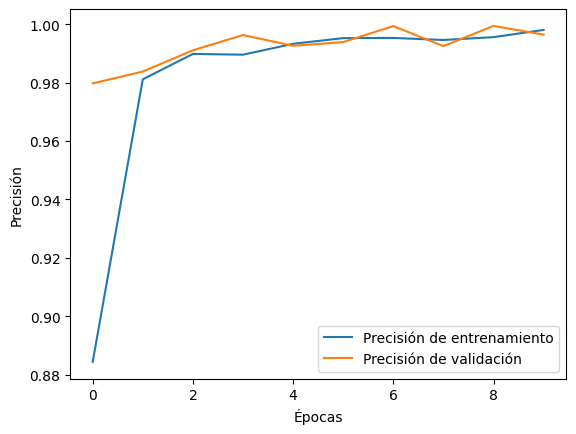

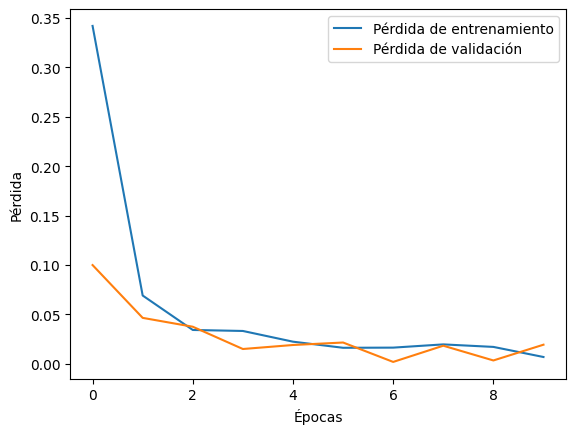

In [15]:
import matplotlib.pyplot as plt

# Graficar la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [16]:
# Evaluación en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_accuracy:.2f}')


611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9963 - loss: 0.0211
Precisión en el conjunto de prueba: 1.00


In [19]:
import numpy as np
import random
import pandas as pd

# Funciones del simulador de blackjack

# Valores de las cartas
card_values_dict = {
    '2': 2, '3': 3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10,
    'J':10, 'Q':10, 'K':10, 'A':11  # El As puede ser 11 o 1; lo manejaremos más adelante
}

# Función para crear una baraja de cartas
def create_deck(num_decks=6):
    deck = []
    for _ in range(num_decks):  # Usando múltiples barajas
        for card in card_values_dict.keys():
            deck.extend([card]*4)
    random.shuffle(deck)
    return deck

# Función para calcular el valor de una mano
def calculate_hand_value(hand):
    value = 0
    aces = 0
    for card in hand:
        card_value = card_values_dict[card]
        value += card_value
        if card == 'A':
            aces += 1
    # Ajustar por ases
    while value > 21 and aces:
        value -= 10
        aces -= 1
    return value

# Función para repartir una carta
def deal_card(deck):
    if len(deck) == 0:
        # Si el mazo está vacío, se baraja uno nuevo
        deck.extend(create_deck())
    return deck.pop()

# Función para determinar si una mano se pasa de 21
def is_bust(hand):
    return calculate_hand_value(hand) > 21

# Función para el juego del crupier
def dealer_play(deck, dealer_hand):
    while calculate_hand_value(dealer_hand) < 17:
        dealer_hand.append(deal_card(deck))
    return dealer_hand

# Función para convertir cartas a valores numéricos para el modelo
def card_to_model_value(card):
    if card in ["J", "Q", "K"]:
        return 10
    elif card == "A":
        return 11
    else:
        return int(card)

# Función para simular un juego
def simulate_game(model, scaler, encoder, deck, run_count, true_count, num_decks=6):
    # Verificar si se debe rebarajar el mazo (por ejemplo, si queda menos del 25% de las cartas)
    if len(deck) < (num_decks * 52) * 0.25:
        deck.clear()
        deck.extend(create_deck(num_decks))
        run_count = 0  # Reiniciar el conteo
        random.shuffle(deck)

    # Manos iniciales
    player_hand = [deal_card(deck), deal_card(deck)]
    dealer_hand = [deal_card(deck), deal_card(deck)]

    # Turno del jugador
    player_turn = True
    player_actions = []
    while player_turn:
        # Obtener características actuales para el modelo
        cards_remaining = len(deck)
        dealer_up_card = card_to_model_value(dealer_hand[0])  # Carta visible del crupier
        initial_card_1 = card_to_model_value(player_hand[0])
        initial_card_2 = card_to_model_value(player_hand[1]) if len(player_hand) > 1 else 0
        run_count = 0  # Implementar conteo si se desea
        true_count = 0  # Igual que arriba

        # Calcular el valor actual de la mano del jugador
        player_hand_value = calculate_hand_value(player_hand)

        # Crear un DataFrame para las características con los nombres de columna adecuados
        features = pd.DataFrame({
            'cards_remaining': [cards_remaining],
            'dealer_up': [dealer_up_card],
            'initial_card_1': [initial_card_1],
            'initial_card_2': [initial_card_2],
            'run_count': [run_count],
            'true_count': [true_count],
            'player_hand_value': [player_hand_value]
        })

        # Asegúrate de que las columnas estén en el mismo orden que durante el entrenamiento
        feature_columns = ['cards_remaining', 'dealer_up', 'initial_card_1', 'initial_card_2', 'run_count', 'true_count', 'player_hand_value']

        # Normalizar las características correspondientes
        features[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']] = scaler.transform(features[['cards_remaining', 'run_count', 'true_count', 'player_hand_value']])

        # Convertir las características a un arreglo NumPy si es necesario
        features_array = features[feature_columns].values

        # Predecir acción
        prediction = model.predict(features_array)
        predicted_action = np.argmax(prediction, axis=1)
        action = encoder.inverse_transform(predicted_action)[0]

        player_actions.append(action)

        if action == 'H':
            # Hit: Repartir una carta
            player_hand.append(deal_card(deck))
            # Verificar si el jugador se pasa
            if is_bust(player_hand):
                player_turn = False
        elif action == 'S':
            # Stand: Terminar turno del jugador
            player_turn = False
        elif action == 'D':
            # Double: El jugador duplica apuesta, recibe una carta y se planta
            player_hand.append(deal_card(deck))
            # Verificar si el jugador se pasa
            if is_bust(player_hand):
                pass  # El jugador pierde
            player_turn = False
        elif action == 'P':
            # Split: Para simplificar, trataremos Split como Stand
            player_turn = False
        else:
            # Cualquier otra acción se trata como Stand
            player_turn = False

    # Verificar si el jugador se pasó
    if is_bust(player_hand):
        return 'loss', player_actions, player_hand, dealer_hand, deck, run_count, true_count

    # Turno del crupier
    dealer_hand = dealer_play(deck, dealer_hand)

    # Determinar resultado
    player_value = calculate_hand_value(player_hand)
    dealer_value = calculate_hand_value(dealer_hand)

    if is_bust(dealer_hand):
        result = 'win'
    elif player_value > dealer_value:
        result = 'win'
    elif player_value < dealer_value:
        result = 'loss'
    else:
        result = 'draw'

    return result, player_actions, player_hand, dealer_hand, deck, run_count, true_count


In [20]:
# Inicializar el deck, run_count y true_count
num_decks = 6
deck = create_deck(num_decks)
run_count = 0  # Puedes implementar el conteo si lo deseas
true_count = 0

# Simular múltiples juegos
num_games = 1000
results = {'win': 0, 'loss': 0, 'draw': 0}
action_counts = []  # Lista para almacenar el número de acciones por juego

for _ in range(num_games):
    result, player_actions, player_hand, dealer_hand, deck, run_count, true_count = simulate_game(
        model, scaler, encoder, deck, run_count, true_count, num_decks=num_decks)
    results[result] +=1
    action_counts.append(len(player_actions))  # Contar las acciones del juego actual

# Calcular estadísticas sobre las acciones
total_actions = sum(action_counts)
average_actions_per_game = total_actions / num_games
max_actions = max(action_counts)
min_actions = min(action_counts)

# Mostrar los resultados
print(f"De {num_games} juegos:")
print(f"Victorias: {results['win']}")
print(f"Derrotas: {results['loss']}")
print(f"Empates: {results['draw']}")
print(f"Tasa de victorias: {results['win']/num_games * 100:.2f}%")
print(f"Total de acciones: {total_actions}")
print(f"Promedio de acciones por juego: {average_actions_per_game:.2f}")
print(f"Máximo de acciones en un juego: {max_actions}")
print(f"Mínimo de acciones en un juego: {min_actions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━